# 📘 Estudo sobre IFRS 9: Simulação de Dados e Modelagem de Perda Esperada

## 📌 Objetivo

Este estudo tem como objetivo simular dados sintéticos realistas para a construção de modelos preditivos voltados ao cálculo da **Perda de Crédito Esperada (ECL – Expected Credit Loss)** conforme definido pela norma **IFRS 9**. O foco está na criação e avaliação de modelos para cada um dos três componentes principais da ECL:

- **PD (Probability of Default)** – Probabilidade de inadimplência;
- **LGD (Loss Given Default)** – Percentual de perda em caso de inadimplência;
- **EAD (Exposure at Default)** – Valor exposto no momento do default.

Através da simulação controlada, é possível analisar e validar técnicas de modelagem, avaliar o impacto de desbalanceamento de classes, e experimentar abordagens de explicabilidade e validação.



## 🎯 Objetivo da Simulação

A norma IFRS 9 exige a mensuração da perda esperada utilizando três componentes:

- **PD (Probability of Default)**: probabilidade do cliente inadimplir.
- **LGD (Loss Given Default)**: proporção do valor que será perdido em caso de inadimplência.
- **EAD (Exposure at Default)**: valor exposto ao risco no momento do default.

A perda esperada é calculada como:

$$
\text{Expected Loss} = PD \times LGD \times EAD
$$

Nosso objetivo aqui é:

- Simular dados de clientes.
- Estimar a PD com regressão logística.
- Comparar a perda esperada com a perda observada.



# 📘 Simulação Detalhada de Modelagem de Risco de Crédito com IFRS 9

## 🌟 Objetivo da Simulação

O objetivo é criar um conjunto de dados artificial para:

* Simular eventos de inadimplência (default) em contratos de crédito;
* Gerar variáveis que afetam esse risco;
* Estimar a **probabilidade de inadimplência (PD)** com um modelo logístico;
* Calcular a **perda esperada (Expected Loss)** de acordo com a norma IFRS 9:

$$
\text{Perda Esperada} = PD \times LGD \times EAD
$$

Onde:

* **PD**: Probabilidade de Inadimplência.
* **LGD**: Proporção perdida caso haja inadimplência (Loss Given Default).
* **EAD**: Valor exposto no momento da inadimplência (Exposure at Default).



## 🔧 1. Parâmetros de Controle

```python
SAMPLE_SIZE = 10000
DEFAULT_RATE_TARGET = 0.03
NOISE_SCALE = 0
np.random.seed(42)
```

Esses parâmetros controlam o ambiente de simulação. Um ambiente sem ruído (`NOISE_SCALE = 0`) permite testar modelos sob condição ideal. O uso de `np.random.seed()` garante reprodutibilidade dos resultados.



## 🪡 2. Simulação das Variáveis Explicativas

### Distribuições utilizadas:

```python
age = np.random.randint(18, 70, size=SAMPLE_SIZE)
```

* Distribuição **Uniforme Discreta** entre 18 e 69 anos.

```python
income = np.random.normal(5000, 2000, size=SAMPLE_SIZE).clip(1000, 20000)
```

* Distribuição **Normal** com média 5000, desvio padrão 2000.
* `.clip()` restringe os valores para evitar extremos.

```python
loan_amount = np.random.normal(20000, 10000, size=SAMPLE_SIZE).clip(5000, 100000)
```

* Valor do empréstimo com média R\$20.000 e limite entre R\$5.000 e R\$100.000.

```python
loan_term = np.random.choice([12, 24, 36, 48, 60], size=SAMPLE_SIZE)
```

* Escolha aleatória entre prazos pré-definidos, com distribuição uniforme.

```python
employment_status = np.random.choice(['CLT', 'autônomo', 'desempregado'],
                                      size=SAMPLE_SIZE, p=[0.6, 0.3, 0.1])
```

* Escolha aleatória com **probabilidades controladas** (60% CLT, 30% autônomo, 10% desempregado).

```python
credit_score = np.random.normal(600, 100, size=SAMPLE_SIZE).clip(300, 850)
```

* Score de crédito com média 600, limitado aos limites usuais do mercado.

```python
region = np.random.choice(['Norte', 'Nordeste', 'Sul', 'Sudeste', 'Centro-Oeste'],
                          size=SAMPLE_SIZE)
```

* Região geográfica sorteada uniformemente.

```python
past_due_days = np.random.poisson(5, size=SAMPLE_SIZE)
```

* Dias de atraso anteriores com **distribuição de Poisson**, ideal para eventos discretos e raros.



## 🔄 3. Codificação de Categorias

```python
employment_map = {'CLT': 0, 'autônomo': 1, 'desempregado': 2}
employment_encoded = pd.Series(employment_status).map(employment_map).values
```

Convertido o status de emprego para valores numéricos. Necessário para regressão logística.



## 📈 4. Função Logística de Risco

A regressão logística é baseada na ideia de que a probabilidade de um evento binário (ex: default ou não) pode ser modelada como:

$$
P(Y = 1 \mid X) = \frac{1}{1 + e^{-Z}}, \text{ onde } Z = \beta_0 + \beta_1 x_1 + \dots + \beta_n x_n
$$

Ou seja, a probabilidade é obtida pela **função sigmoide** (ou logística), que transforma qualquer valor real num intervalo entre 0 e 1.

No nosso caso, construímos `logit_base` como:

```python
logit_base = (
    -6.0
    - 0.01 * credit_score
    + 0.0002 * loan_amount
    - 0.0003 * income
    + 0.5 * employment_encoded
    + NOISE_SCALE * np.random.normal(0, 1, SAMPLE_SIZE)
)
```

Cada variável contribui linearmente para o logit (Z), e os coeficientes foram escolhidos com base na interpretação econômica:

* `credit_score`: quanto maior, menor o risco.
* `loan_amount`: quanto maior, maior o risco.
* `income`: quanto maior a renda, menor o risco.
* `employment_encoded`: desemprego eleva o risco.



## 🔧 5. Ajuste do Intercepto

Ao montar um modelo com função logística simulada, não temos controle direto sobre a taxa média de inadimplência gerada.

Por isso, usamos um método de minimização numérica para encontrar o **intercepto ideal** que faz com que a média da probabilidade simulada atinja o valor desejado (`DEFAULT_RATE_TARGET`).

```python
def adjust_intercept(intercept):
    logits = logit_base + intercept
    probs = 1 / (1 + np.exp(-logits))
    return abs(probs.mean() - DEFAULT_RATE_TARGET)

res = minimize_scalar(adjust_intercept, bounds=(-10, 10), method='bounded')
optimal_intercept = res.x
```

Esse ajuste é essencial para controlar a taxa de inadimplência global da base simulada.



## 📊 6. Geração da Probabilidade e Simulação do Evento

Uma vez encontrado o `optimal_intercept`, computamos:

```python
logits = logit_base + optimal_intercept
default_prob = 1 / (1 + np.exp(-logits))
default = np.random.binomial(1, default_prob)
```

### Sobre `np.random.binomial(1, p)`:

* Modelo binomial com `n = 1`: representa um evento binário (inadimpliu ou não);
* `p`: probabilidade individual estimada;
* Resultado: `1` (inadimplência) ou `0` (pagamento regular).

Esse passo converte as probabilidades em **eventos reais** (defaults), permitindo simular o comportamento real de clientes com diferentes características.




## 📘 5. Simulação Realista da LGD

A **LGD (Loss Given Default)** representa a fração do valor exposto que será perdida caso ocorra inadimplência. Como se trata de uma variável contínua, com valores geralmente entre 0 e 1 (mas podendo superar 1 em contextos reais com multas, juros e custos), utilizamos uma **função logística invertida** para simular a LGD de forma realista:

```python
lgd_log = (
    -0.0005 * credit_score
    + 0.3 * employment_encoded
    + 0.0004 * past_due_days
    + np.random.normal(0, 0.4, SAMPLE_SIZE)
)
lgd_raw = 1 / (1 + np.exp(-lgd_log))
lgd = np.where(default == 1, lgd_raw, 0)
```

### Observações:

- Apenas clientes inadimplentes recebem valores de LGD diferentes de zero;
- A transformação logística garante que os valores fiquem entre 0 e 1;
- As variáveis explicativas refletem a lógica econômica: menor score e maior atraso implicam maiores perdas.

---

## 📘 6. Simulação Realista da EAD

A **EAD (Exposure at Default)** representa o valor financeiro em risco no momento da inadimplência. A distribuição dessa variável costuma ser assimétrica e com cauda longa, pois depende do uso efetivo da linha de crédito. Para simulação realista, utilizamos uma transformação exponencial:

```python
ead_log = (
    np.log(loan_amount + 1)
    - 0.001 * credit_score
    + 0.0005 * past_due_days
    - 0.0001 * income
    + 0.05 * employment_encoded
    + np.random.normal(0, 0.3, SAMPLE_SIZE)
)
ead = np.exp(ead_log)
```

### Observações:

- Utiliza `np.log(loan_amount + 1)` para capturar a relação não linear entre o valor contratado e a exposição final;
- A saída final (com `np.exp`) resulta em uma distribuição com assimetria positiva, coerente com a natureza da EAD;
- Todas as observações recebem valores de EAD (mesmo as adimplentes).

---

## 🧪 7. Modelagem Preditiva de PD, LGD e EAD

Com os dados simulados, treinamos:

1. Um modelo de **regressão logística** para prever a **PD**;
2. Um modelo **Random Forest Regressor** para prever a **LGD**, treinado **apenas com inadimplentes**;
3. Outro **Random Forest Regressor** para prever a **EAD**, treinado com **todos os dados**.

Essa abordagem reflete a prática real das instituições financeiras, que estimam essas três componentes separadamente para depois calcular a **Perda Esperada**.

```python
# Modelo de PD
model_pd = LogisticRegression()
model_pd.fit(df.loc[train_idx, features], df.loc[train_idx, 'default'])
df['pd_estimada'] = model_pd.predict_proba(df[features])[:, 1]

# Modelo de LGD
train_lgd = df.loc[train_idx].query("default == 1")
model_lgd = RandomForestRegressor(n_estimators=100, random_state=42)
model_lgd.fit(train_lgd[features], train_lgd['lgd'])
df['lgd_estimada'] = model_lgd.predict(df[features])

# Modelo de EAD
model_ead = RandomForestRegressor(n_estimators=100, random_state=42)
model_ead.fit(df.loc[train_idx, features], df.loc[train_idx, 'ead'])
df['ead_estimada'] = model_ead.predict(df[features])
```

---

## 🧮 8. Cálculo da Perda Esperada

Com as estimativas de PD, LGD e EAD, calculamos a **perda esperada (Expected Loss)**:

```python
df['loss_esperada'] = df['pd_estimada'] * df['lgd_estimada'] * df['ead_estimada']
```

A perda **realizada** é conhecida pela simulação:

```python
realized_loss = default * lgd * ead
```

A comparação entre `loss_esperada` e `realized_loss` permite validar o desempenho dos modelos em termos de previsão de risco financeiro agregado.



In [141]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from scipy.optimize import minimize_scalar
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
from utils import get_classes_cdf, plot_hist, plot_cdf_ks
from sklearn.ensemble import RandomForestRegressor
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

In [159]:
# ----------------------------------------
# 🎛️ Parâmetros de controle
# ----------------------------------------
SAMPLE_SIZE = 100_000
DEFAULT_RATE_TARGET = 0.05
NOISE_SCALE = 1
np.random.seed(42)

# ----------------------------------------
# 🔢 Simulação das variáveis
# ----------------------------------------
age = np.random.randint(18, 70, size=SAMPLE_SIZE)
income = np.random.normal(5000, 2000, size=SAMPLE_SIZE).clip(1000, 20000)
loan_amount = np.random.normal(20000, 10000, size=SAMPLE_SIZE).clip(5000, 100000)
loan_term = np.random.choice([12, 24, 36, 48, 60], size=SAMPLE_SIZE)
employment_status = np.random.choice(
    ['CLT', 'autônomo', 'desempregado'], size=SAMPLE_SIZE, p=[0.6, 0.3, 0.1]
)
credit_score = np.random.normal(600, 100, size=SAMPLE_SIZE).clip(300, 850)
region = np.random.choice(['Norte', 'Nordeste', 'Sul', 'Sudeste', 'Centro-Oeste'], size=SAMPLE_SIZE)
past_due_days = np.random.poisson(5, size=SAMPLE_SIZE)

# 🔁 Codificação para função de risco
employment_map = {'CLT': 0, 'autônomo': 1, 'desempregado': 2}
employment_encoded = pd.Series(employment_status).map(employment_map).values

# ----------------------------------------
# 📉 Simulação da Probabilidade de Default (PD)
# ----------------------------------------
logit_base = (
    -6.0
    - 0.01 * credit_score
    + 0.0002 * loan_amount
    - 0.0003 * income
    + 0.5 * employment_encoded
    + NOISE_SCALE * np.random.normal(0, 1, SAMPLE_SIZE)
)

def adjust_intercept(intercept):
    logits = logit_base + intercept
    probs = 1 / (1 + np.exp(-logits))
    return abs(probs.mean() - DEFAULT_RATE_TARGET)

res = minimize_scalar(adjust_intercept, bounds=(-10, 10), method='bounded')
optimal_intercept = res.x
logits = logit_base + optimal_intercept
default_prob = 1 / (1 + np.exp(-logits))
default = np.random.binomial(1, default_prob)

# ----------------------------------------
# 📘 Simulação realista da LGD
# ----------------------------------------
lgd_log = (
    -0.0005 * credit_score
    + 0.3 * employment_encoded
    + 0.0004 * past_due_days
    + np.random.normal(0, 0.4, SAMPLE_SIZE)
)
lgd_raw = 1 / (1 + np.exp(-lgd_log))  # função logística para manter entre (0,1)
lgd = np.where(default == 1, lgd_raw, 0)

# ----------------------------------------
# 📘 Simulação realista da EAD
# ----------------------------------------
ead_log = (
    np.log(loan_amount + 1)
    - 0.001 * credit_score
    + 0.0005 * past_due_days
    - 0.0001 * income
    + 0.05 * employment_encoded
    + np.random.normal(0, 0.3, SAMPLE_SIZE)
)
ead = np.exp(ead_log)

# ----------------------------------------
# 📘 Cálculo da perda realizada
# ----------------------------------------
realized_loss = default * lgd * ead

# ----------------------------------------
# 📋 Dataset final
# ----------------------------------------
df = pd.DataFrame({
    'age': age,
    'income': income,
    'loan_amount': loan_amount,
    'loan_term': loan_term,
    'employment_status': employment_status,
    'credit_score': credit_score,
    'region': region,
    'past_due_days': past_due_days,
    'default': default,
    'lgd': lgd,
    'ead': ead,
    'realized_loss': realized_loss
})

print(f"Taxa de inadimplência simulada: {df['default'].mean():.2%}")

# ----------------------------------------
# 🔧 Modelagem: codificação e features
# ----------------------------------------
expected_dummies = [
    'employment_status_autônomo', 'employment_status_desempregado',
    'region_Nordeste', 'region_Sudeste', 'region_Sul', 'region_Centro-Oeste'
]
df = pd.get_dummies(df, columns=['employment_status', 'region'], drop_first=True)
for col in expected_dummies:
    if col not in df.columns:
        df[col] = 0

features = [
    'age', 'income', 'loan_amount', 'loan_term',
    'credit_score', 'past_due_days'
] + expected_dummies

# ----------------------------------------
# 🧪 Separação com índices
# ----------------------------------------
train_idx, test_idx = train_test_split(
    df.index, test_size=0.3, stratify=df['default'], random_state=42
)

# ----------------------------------------
# 🔍 Modelo de PD
# ----------------------------------------
model_pd = LogisticRegression()
model_pd.fit(df.loc[train_idx, features], df.loc[train_idx, 'default'])
df['pd_estimada'] = model_pd.predict_proba(df[features])[:, 1]

# ----------------------------------------
# 📘 Estimação de LGD (apenas inadimplentes no treino)
# ----------------------------------------
train_lgd = df.loc[train_idx].query("default == 1")
model_lgd = RandomForestRegressor(n_estimators=100, random_state=42)
model_lgd.fit(train_lgd[features], train_lgd['lgd'])
df['lgd_estimada'] = model_lgd.predict(df[features])

# ----------------------------------------
# 📘 Estimação de EAD (todos os clientes)
# ----------------------------------------
model_ead = RandomForestRegressor(n_estimators=100, random_state=42)
model_ead.fit(df.loc[train_idx, features], df.loc[train_idx, 'ead'])
df['ead_estimada'] = model_ead.predict(df[features])

# ----------------------------------------
# 📈 Calcular Perda Esperada com estimativas
# ----------------------------------------
df_resultado = df.loc[test_idx].copy()
df_resultado['loss_realizada'] = df_resultado['realized_loss']
df_resultado['loss_esperada_estim'] = (
    df_resultado['pd_estimada']
    * df_resultado['lgd_estimada']
    * df_resultado['ead_estimada']
)

# ----------------------------------------
# 📊 Comparação final
# ----------------------------------------
loss_total_estimada = df_resultado['loss_esperada_estim'].sum()
loss_total_realizada = df_resultado['loss_realizada'].sum()
diferenca = loss_total_estimada - loss_total_realizada
percentual = abs(diferenca / loss_total_realizada) * 100

print("\n📊 Comparação Final:")
print(f"🔎 Perda total estimada:   R$ {loss_total_estimada:,.2f}")
print(f"📌 Perda total realizada:  R$ {loss_total_realizada:,.2f}")
print(f"📈 Diferença absoluta:     R$ {abs(diferenca):,.2f}")
print(f"📉 Diferença percentual:   {percentual:.2f}%")
print("⬆ Modelo superestimou a perda." if diferenca > 0 else "⬇ Modelo subestimou a perda.")

Taxa de inadimplência simulada: 5.05%


/Users/cristianooliveira/Documents/estudos_ifrs9/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



📊 Comparação Final:
🔎 Perda total estimada:   R$ 9,990,201.51
📌 Perda total realizada:  R$ 9,929,045.00
📈 Diferença absoluta:     R$ 61,156.51
📉 Diferença percentual:   0.62%
⬆ Modelo superestimou a perda.


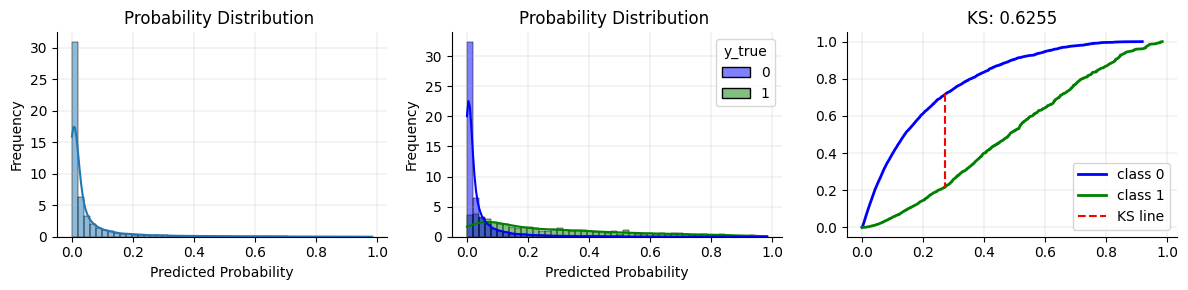

In [161]:

# 📊 Avaliação
df_classifier = df.loc[test_idx][['default', 'pd_estimada']].rename(columns={'default': 'y_true', 'pd_estimada': 'score'})
mask0 = (df_classifier['y_true'] == 0)
class0 = df_classifier['score'][mask0]
class1 = df_classifier['score'][~mask0]
ks = ks_2samp(class0, class1).statistic

# Supondo que as funções gráficas existam:
cdf_ = get_classes_cdf(df=df_classifier, proba_col='score', true_value_col='y_true')

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax1, ax2, ax3 = ax.flatten()
plot_hist(df_classifier, 'Probability Distribution ', ax1, hue=False)
plot_hist(df_classifier, 'Probability Distribution ', ax2, color0='b', color1='g')
plot_cdf_ks(cdf_, ks, ax3, color0='b', color1='g')
plt.tight_layout()
plt.show()

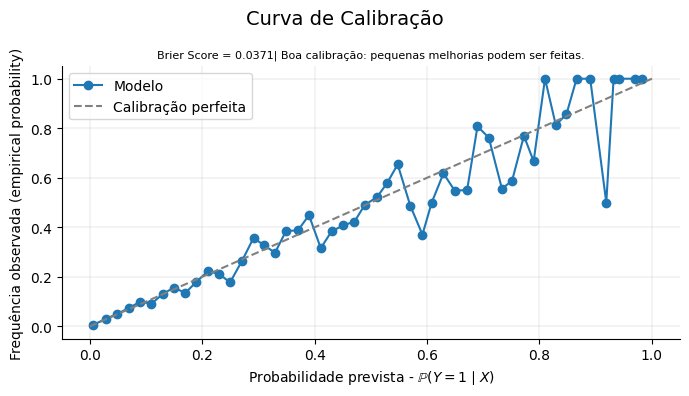

In [163]:

# Dados de teste
y_true = df.loc[test_idx, 'default']
y_score = df.loc[test_idx, 'pd_estimada']
brier = brier_score_loss(y_true, y_score)

# Mensagem de recomendação
if brier < 0.02:
    recomendacao = "Excelente calibração: o modelo está bem ajustado."
elif brier < 0.05:
    recomendacao = "Boa calibração: pequenas melhorias podem ser feitas."
elif brier < 0.08:
    recomendacao = "Calibração moderada: considere aplicar técnicas como Platt Scaling ou Isotonic Regression."
else:
    recomendacao = "Calibração ruim: recomenda-se revisar o modelo e aplicar uma técnica de recalibração."
# Obter curva de calibração
prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=50, strategy='uniform')

# Plotar
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(prob_pred, prob_true, marker='o', label='Modelo')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibração perfeita')

# Títulos principais e subtítulo com fonte menor
fig.suptitle('Curva de Calibração', fontsize=14)
ax.set_title(f'Brier Score = {brier:.4f}| {recomendacao}', fontsize=8)

# Eixos e legenda
ax.set_xlabel('Probabilidade prevista - $\mathbb{P}(Y = 1 \mid X)$')
ax.set_ylabel('Frequência observada (empirical probability)')
ax.legend()

# Estética
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
ax.xaxis.grid(True, linestyle='-', linewidth=0.2)
plt.tight_layout()
plt.show()

## Análise da PD Isoladamente

In [167]:
# ----------------------------------------
# 📌 Valores fixos para LGD e EAD
# ----------------------------------------
LGD_FIXO = 0.45
EAD_FIXO = 10_000
print(f"\n🔧 LGD fixo usado: {LGD_FIXO:.4f}")
print(f"🔧 EAD fixo usado: R$ {EAD_FIXO:,.2f}")

# ----------------------------------------
# ✅ Cenário base (PD calibrada)
# ----------------------------------------
df_resultado['loss_esperada_fixos_calibrada'] = df_resultado['pd_estimada'] * LGD_FIXO * EAD_FIXO
df_resultado['loss_esperada_estim_calibrada'] = (
    df_resultado['pd_estimada'] * df_resultado['lgd_estimada'] * df_resultado['ead_estimada']
)
df_resultado['loss_realizada_fixos'] = df_resultado['default'] * LGD_FIXO * EAD_FIXO
df_resultado['loss_realizada_estim'] = df_resultado['realized_loss']

# 📊 Totais e erros (modelo calibrado)
loss_fix_calibrada = df_resultado['loss_esperada_fixos_calibrada'].sum()
loss_estim_calibrada = df_resultado['loss_esperada_estim_calibrada'].sum()
loss_real_fixos = df_resultado['loss_realizada_fixos'].sum()
loss_real_estim = df_resultado['loss_realizada_estim'].sum()
erro_pct_fix_base = abs(loss_fix_calibrada - loss_real_fixos) / loss_real_fixos * 100
erro_pct_estim_base = abs(loss_estim_calibrada - loss_real_estim) / loss_real_estim * 100

# 🖨️ Resultado do modelo calibrado
print("\n✅ Modelo Calibrado (PD original)")
print(f"🔹 LGD/EAD fixos:     R$ {loss_fix_calibrada:,.2f} | Real: R$ {loss_real_fixos:,.2f} | Erro %: {erro_pct_fix_base:.2f}%")
print(f"🔹 LGD/EAD estimados: R$ {loss_estim_calibrada:,.2f} | Real: R$ {loss_real_estim:,.2f} | Erro %: {erro_pct_estim_base:.2f}%")

# ----------------------------------------
# 🎯 Escalas de descalibração da PD
# ----------------------------------------
multiplicadores = [0.6, 0.8, 1.2, 1.4, 2, 3, 4, 5]

# ----------------------------------------
# 📊 Loop de avaliação para diferentes níveis de descalibração
# ----------------------------------------
for c in multiplicadores:
    print(f"\n🔄 Descalibração com multiplicador = {c:.2f}")

    # 🔁 PD descalibrada com log-odds
    odds = df_resultado['pd_estimada'] / (1 - df_resultado['pd_estimada'])
    df_resultado['pd_descalibrada'] = (odds * c) / (1 + odds * c)
    df_resultado['pd_descalibrada'] = df_resultado['pd_descalibrada'].clip(0.0001, 0.9999)

    # ========================
    # 🧮 CENÁRIO 1 - LGD/EAD FIXOS
    # ========================
    df_resultado['loss_esperada_fixos_descalibrada'] = df_resultado['pd_descalibrada'] * LGD_FIXO * EAD_FIXO
    df_resultado['loss_realizada_fixos'] = df_resultado['default'] * LGD_FIXO * EAD_FIXO

    loss_est_fix = df_resultado['loss_esperada_fixos_descalibrada'].sum()
    loss_real_fix = df_resultado['loss_realizada_fixos'].sum()
    erro_pct_fix = abs(loss_est_fix - loss_real_fix) / loss_real_fix * 100

    print(f"📘 CENÁRIO 1 - LGD/EAD FIXOS")
    print(f"🔹 Estimada: R$ {loss_est_fix:,.2f}")
    print(f"🔹 Real:     R$ {loss_real_fix:,.2f}")
    print(f"📉 Erro percentual: {erro_pct_fix:.2f}%")

    # ========================
    # 🧮 CENÁRIO 2 - LGD/EAD ESTIMADOS
    # ========================
    df_resultado['loss_esperada_estim_descalibrada'] = (
        df_resultado['pd_descalibrada'] * df_resultado['lgd_estimada'] * df_resultado['ead_estimada']
    )
    df_resultado['loss_realizada_estim'] = df_resultado['realized_loss']

    loss_est_estim = df_resultado['loss_esperada_estim_descalibrada'].sum()
    loss_real_estim = df_resultado['loss_realizada_estim'].sum()
    erro_pct_estim = abs(loss_est_estim - loss_real_estim) / loss_real_estim * 100

    print(f"\n📘 CENÁRIO 2 - LGD/EAD ESTIMADOS")
    print(f"🔹 Estimada: R$ {loss_est_estim:,.2f}")
    print(f"🔹 Real:     R$ {loss_real_estim:,.2f}")
    print(f"📉 Erro percentual: {erro_pct_estim:.2f}%")


🔧 LGD fixo usado: 0.4500
🔧 EAD fixo usado: R$ 10,000.00

✅ Modelo Calibrado (PD original)
🔹 LGD/EAD fixos:     R$ 6,906,631.17 | Real: R$ 6,822,000.00 | Erro %: 1.24%
🔹 LGD/EAD estimados: R$ 9,990,201.51 | Real: R$ 9,929,045.00 | Erro %: 0.62%

🔄 Descalibração com multiplicador = 0.60
📘 CENÁRIO 1 - LGD/EAD FIXOS
🔹 Estimada: R$ 4,733,106.99
🔹 Real:     R$ 6,822,000.00
📉 Erro percentual: 30.62%

📘 CENÁRIO 2 - LGD/EAD ESTIMADOS
🔹 Estimada: R$ 7,081,023.63
🔹 Real:     R$ 9,929,045.00
📉 Erro percentual: 28.68%

🔄 Descalibração com multiplicador = 0.80
📘 CENÁRIO 1 - LGD/EAD FIXOS
🔹 Estimada: R$ 5,871,259.76
🔹 Real:     R$ 6,822,000.00
📉 Erro percentual: 13.94%

📘 CENÁRIO 2 - LGD/EAD ESTIMADOS
🔹 Estimada: R$ 8,621,296.73
🔹 Real:     R$ 9,929,045.00
📉 Erro percentual: 13.17%

🔄 Descalibração com multiplicador = 1.20
📘 CENÁRIO 1 - LGD/EAD FIXOS
🔹 Estimada: R$ 7,861,976.08
🔹 Real:     R$ 6,822,000.00
📉 Erro percentual: 15.24%

📘 CENÁRIO 2 - LGD/EAD ESTIMADOS
🔹 Estimada: R$ 11,229,203.09
🔹 Real:

---

## 🎯 Ajuste do Score de PD e Impacto na Perda Esperada

Após treinar o modelo de **PD (Probability of Default)** com regressão logística e comparar as perdas estimadas com as perdas realizadas, aplicamos uma **transformação nos scores preditos** com o objetivo de:

- Observar o efeito de um **recalibramento** ou **"ajuste escalar"** sobre as estimativas de perda;
- Estudar como diferentes níveis de **agressividade do score** afetam a acurácia da mensuração da **perda esperada total**;
- Verificar qual constante produz a menor discrepância percentual entre a **perda estimada** e a **perda realizada**.

### 🧮 Fórmula de Ajuste Aplicada

A transformação aplicada à PD estimada é a seguinte:

$$
\text{PD}_{ajustada} = \frac{c \cdot \text{PD}_{modelo}}{c \cdot \text{PD}_{modelo} + (1 - \text{PD}_{modelo})}
$$

Onde:
- $\text{PD}_{modelo}$ é a probabilidade predita pelo modelo original.
- $c$ é uma **constante de ajuste** variando entre 20 e 39.

Esta fórmula tem origem na ideia de **calibração log-odds**, frequentemente associada ao conceito de **Platt scaling** e ajustes de **isotonic regression**, ainda que aqui seja aplicada uma versão escalar direta sobre as razões de chances (odds ratio):

$$
\text{Odds}_{ajustada} = c \cdot \text{Odds}_{modelo}
$$

E como:

$$
\text{PD} = \frac{\text{Odds}}{1 + \text{Odds}} \Rightarrow \text{PD}_{ajustada} = \frac{c \cdot \text{Odds}_{modelo}}{1 + c \cdot \text{Odds}_{modelo}}
$$

Essa técnica é uma forma de testar cenários em que o modelo pode estar **subestimando ou superestimando** o risco de inadimplência.

---

## 🧪 Mensuração do Impacto

Para cada valor de $c$ no intervalo de 20 a 39, realizamos:

1. **Reajuste do score de PD** com a fórmula acima.
2. **Reestimativa da perda esperada**:

$$
\text{Expected Loss} = PD_{ajustada} \times LGD \times EAD
$$

3. Comparação da **perda total esperada** com a **perda total realizada**:

```python
diferença = perda_esperada_total - perda_realizada_total
percentual = abs(diferenca / perda_realizada_total) * 100
```



In [122]:

for c in np.arange(1, 3.1, 0.2): 
    output_modelo = 'pd_estimada'
    vr = 'default_real'

    df['pd_ajustada'] = (df['pd_estimada']*c)/((df['pd_estimada']*c)+(1-df['pd_estimada']))
    # ➕ Trazer LGD e perda realizada para o conjunto de teste
    df['loss_realizada'] = df['realized_loss'].values

    # 📈 Calcular perda esperada
    df['loss_esperada'] = df['pd_ajustada'] * df['lgd_estimada'] * df['ead_estimada']

    # 🔍 Comparar a soma total das perdas
    loss_total_realizada = df['loss_realizada'].sum()
    loss_total_estimada = df['loss_esperada'].sum()

    # 🧮 Calcular diferença absoluta e percentual
    diferenca = loss_total_estimada - loss_total_realizada
    percentual = abs(diferenca / loss_total_realizada) * 100

    # 🖨️ Mostrar resultado
    # print(f"🔎 Perda total estimada:   R$ {loss_total_estimada:,.2f}")
    # print(f"📌 Perda total realizada:  R$ {loss_total_realizada:,.2f}")
    # print(f"📈 Diferença absoluta:     R$ {diferenca:,.2f}")
    print(f"📉 Constante: {c} - Diferença percentual:   {percentual:.2f}%")
    print("⬆ Modelo superestimou a perda." if diferenca > 0 else "⬇ Modelo subestimou a perda.")

📉 Constante: 1.0 - Diferença percentual:   0.54%
⬆ Modelo superestimou a perda.
📉 Constante: 1.2 - Diferença percentual:   13.57%
⬆ Modelo superestimou a perda.
📉 Constante: 1.4 - Diferença percentual:   25.58%
⬆ Modelo superestimou a perda.
📉 Constante: 1.5999999999999999 - Diferença percentual:   36.75%
⬆ Modelo superestimou a perda.
📉 Constante: 1.7999999999999998 - Diferença percentual:   47.21%
⬆ Modelo superestimou a perda.
📉 Constante: 1.9999999999999998 - Diferença percentual:   57.05%
⬆ Modelo superestimou a perda.
📉 Constante: 2.1999999999999997 - Diferença percentual:   66.37%
⬆ Modelo superestimou a perda.
📉 Constante: 2.3999999999999995 - Diferença percentual:   75.22%
⬆ Modelo superestimou a perda.
📉 Constante: 2.5999999999999996 - Diferença percentual:   83.65%
⬆ Modelo superestimou a perda.
📉 Constante: 2.8 - Diferença percentual:   91.70%
⬆ Modelo superestimou a perda.
📉 Constante: 2.9999999999999996 - Diferença percentual:   99.42%
⬆ Modelo superestimou a perda.


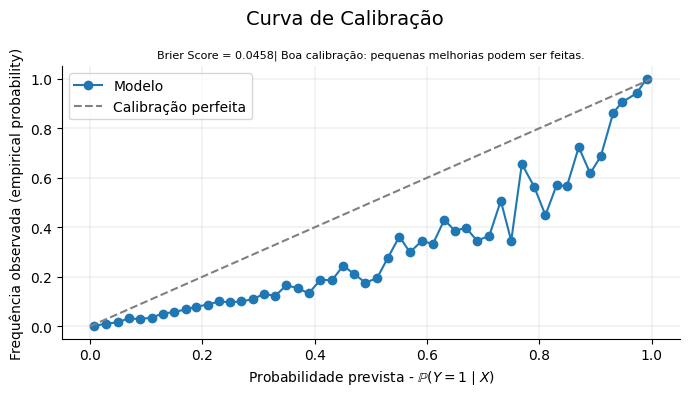

In [ ]:
# Apenas dados de teste
y_true = df.loc[test_idx, 'default']
y_score = df.loc[test_idx, 'pd_ajustada']

brier = brier_score_loss(y_true, y_score)

# Mensagem de recomendação
if brier < 0.02:
    recomendacao = "Excelente calibração: o modelo está bem ajustado."
elif brier < 0.05:
    recomendacao = "Boa calibração: pequenas melhorias podem ser feitas."
elif brier < 0.08:
    recomendacao = "Calibração moderada: considere aplicar técnicas como Platt Scaling ou Isotonic Regression."
else:
    recomendacao = "Calibração ruim: recomenda-se revisar o modelo e aplicar uma técnica de recalibração."
# Obter curva de calibração
prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=50, strategy='uniform')

# Plotar
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(prob_pred, prob_true, marker='o', label='Modelo')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibração perfeita')

# Títulos principais e subtítulo com fonte menor
fig.suptitle('Curva de Calibração', fontsize=14)
ax.set_title(f'Brier Score = {brier:.4f}| {recomendacao}', fontsize=8)

# Eixos e legenda
ax.set_xlabel('Probabilidade prevista - $\mathbb{P}(Y = 1 \mid X)$')
ax.set_ylabel('Frequência observada (empirical probability)')
ax.legend()

# Estética
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
ax.xaxis.grid(True, linestyle='-', linewidth=0.2)
plt.tight_layout()
plt.show()

In [42]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB

# Define the classifiers to be compared in the study.
#
# Note that we use a variant of the logistic regression model that can
# automatically tune its regularization parameter.
#
# For a fair comparison, we should run a hyper-parameter search for all the
# classifiers but we don't do it here for the sake of keeping the example code
# concise and fast to execute.
lr = LogisticRegressionCV(
    Cs=np.logspace(-6, 6, 101), cv=10, scoring="neg_log_loss", max_iter=1_000
)
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0)
rfc = RandomForestClassifier(random_state=42)

clf_list = [
    (lr, "Logistic Regression"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]



/Users/cristianooliveira/Documents/estudos_ifrs9/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🔎 Perda total estimada:   R$ 11,084,264.20
📌 Perda total realizada:  R$ 26,936,789.90
📈 Diferença absoluta:     R$ 15,852,525.70
📉 Diferença percentual:   58.85%
⬇ Modelo subestimou a perda.
🔎 Perda total estimada:   R$ 9,917,318.08
📌 Perda total realizada:  R$ 26,936,789.90
📈 Diferença absoluta:     R$ 17,019,471.81
📉 Diferença percentual:   63.18%
⬇ Modelo subestimou a perda.
🔎 Perda total estimada:   R$ 16,302,698.40
📌 Perda total realizada:  R$ 26,936,789.90
📈 Diferença absoluta:     R$ 10,634,091.49
📉 Diferença percentual:   39.48%
⬇ Modelo subestimou a perda.
🔎 Perda total estimada:   R$ 10,538,558.47
📌 Perda total realizada:  R$ 26,936,789.90
📈 Diferença absoluta:     R$ 16,398,231.43
📉 Diferença percentual:   60.88%
⬇ Modelo subestimou a perda.


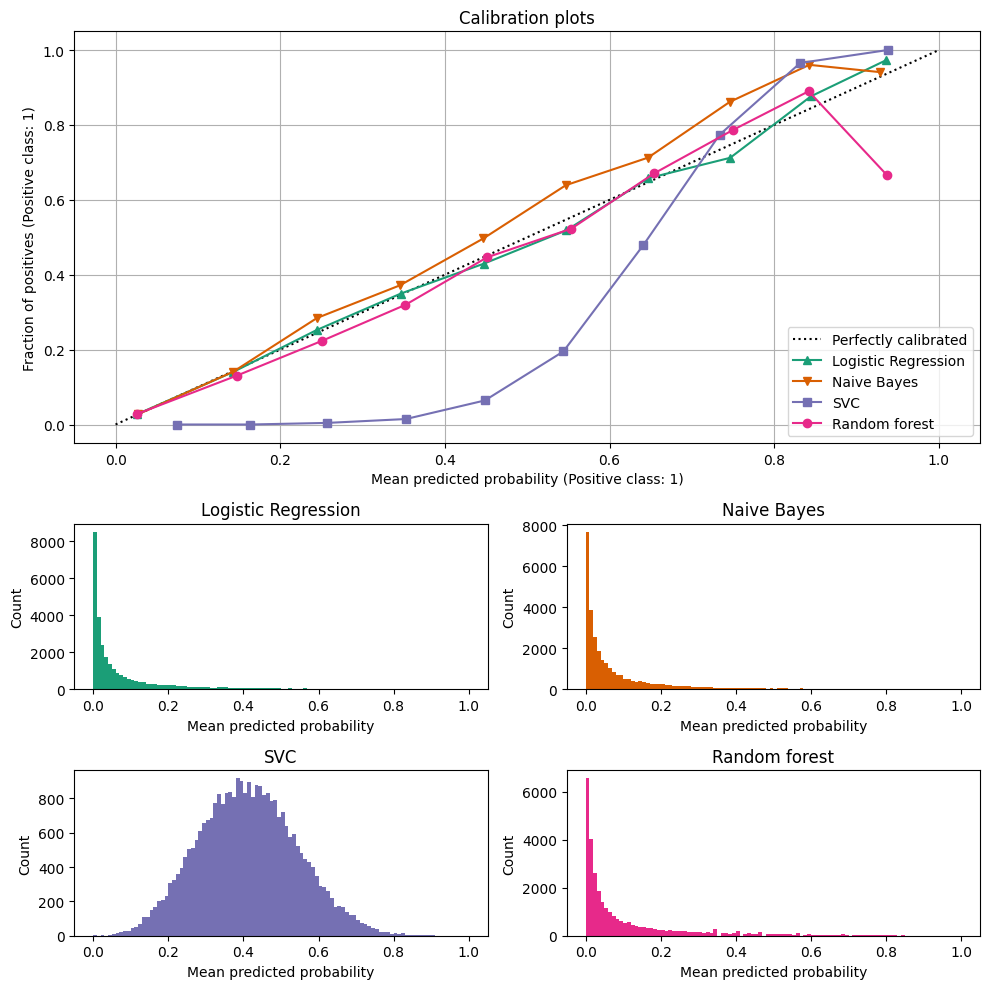

In [55]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(df.loc[train_idx, features], df.loc[train_idx, 'default'])
    # 🔍 Selecionar subconjunto de teste
    df_resultado = df.loc[test_idx].copy()
    df_resultado['pd_estimada']=clf.predict_proba(df_resultado[features])[:, 1]

    # ➕ Trazer LGD e perda realizada diretamente do DataFrame original
    df_resultado['loss_realizada'] = df_resultado['realized_loss']

    # 📈 Calcular perda esperada com base na PD estimada
    df_resultado['loss_esperada'] = df_resultado['pd_estimada'] * df_resultado['lgd'] * df_resultado['ead']

    # 🔍 Comparar a soma total das perdas
    loss_total_realizada = df_resultado['loss_realizada'].sum()
    loss_total_estimada = df_resultado['loss_esperada'].sum()

    # 🧮 Calcular diferença absoluta e percentual
    diferenca = loss_total_estimada - loss_total_realizada
    percentual = abs(diferenca / loss_total_realizada) * 100

    # 🖨️ Mostrar resultado
    print(f"🔎 Perda total estimada:   R$ {loss_total_estimada:,.2f}")
    print(f"📌 Perda total realizada:  R$ {loss_total_realizada:,.2f}")
    print(f"📈 Diferença absoluta:     R$ {abs(diferenca):,.2f}")
    print(f"📉 Diferença percentual:   {percentual:.2f}%")
    print("⬆ Modelo superestimou a perda." if diferenca > 0 else "⬇ Modelo subestimou a perda.")
    display = CalibrationDisplay.from_estimator(
        clf,
        df.loc[test_idx, features], 
        df.loc[test_idx, 'default'],
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=100,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()